# Suite minimisante (linéaire)

In [1]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.geom2d import CSG2d, Circle, Rectangle
import copy
from numpy.random import randint
import numpy as np
import matplotlib.pyplot as plt

importing NGSolve-6.2.2105-9-g5a835126f


## 1) Définition du maillage


In [2]:
def generate_fitted_circle_mesh(N):
    geo = CSG2d()
    R=1
    x = R*2*(np.append(np.insert(np.arange(0.5,N+0.5),0,0),N)/N-0.5)
    
    circle1 = Circle( center=(0,0), radius=R, bc="left_up" ) * Rectangle( pmin=(-R,0), pmax=(0,R))
    circle2 = Circle( center=(0,0), radius=R, bc="left_bot" ) * Rectangle( pmin=(-R,-R), pmax=(0,0))
    circle3 = Circle( center=(0,0), radius=R, bc="right_bot" ) * Rectangle( pmin=(0,-R), pmax=(R,0))
    circle4 = Circle( center=(0,0), radius=R, bc="right_up" ) * Rectangle( pmin=(0,0), pmax=(R,R))
    
    materials = ["iron","air"]
    
    for i in range(len(x)-1):
        geo.Add(Rectangle( pmin=(x[i],-R), pmax=(x[i+1],R), mat = materials[i%2] ) * (circle1 + circle2 + circle3 +circle4))

    #m = geo.GenerateMesh(maxh=max([R/N,1/30])) # On doit fixer la taille du maillage sinon le volume change à cause des elts grossiers
    m = geo.GenerateMesh(maxh=1/100)
    return Mesh(m)


## 2) Définition des problèmes éléments finis

In [3]:
PHI=1

def solvePb(mu,mesh):
    fespace_H1 = H1(mesh, order=1)
    fespace_H1.FreeDofs()[0] = False
    phi = fespace_H1.TrialFunction()
    psi = fespace_H1.TestFunction()
    K = BilinearForm(fespace_H1, symmetric=True)
    K +=  grad(psi)*mu*grad(phi)*dx
    
    l1 = LinearForm(fespace_H1)
    l1 += -psi*PHI*sqrt(1-x**2)*ds(definedon=mesh.Boundaries("left_up|right_up"))
    l1 += psi*PHI*sqrt(1-x**2)*ds(definedon=mesh.Boundaries("left_bot|right_bot"))

    l2 = LinearForm(fespace_H1)
    l2 += -psi*PHI*sqrt(1-y**2)*ds(definedon=mesh.Boundaries("left_up|left_bot"))
    l2 += psi*PHI*sqrt(1-y**2)*ds(definedon=mesh.Boundaries("right_up|right_bot"))
    
    K.Assemble() ; Kdec = K.mat.Inverse(inverse="sparsecholesky")
    l1.Assemble()
    l2.Assemble()
    
    phi1 = GridFunction(fespace_H1)  # solution
    phi1.vec.data =     Kdec * l1.vec
    phi2 = GridFunction(fespace_H1)  # solution
    phi2.vec.data =     Kdec * l2.vec
    
    return(phi1, phi2)


def compliance(phi,mu,mesh):
    return Integrate(grad(phi)*mu* grad(phi)* dx,mesh) /2

## 3) Calculs

In [4]:
J1=[]
J2=[]
Jdiff = []
temoin = []
mu0 = 4e-7*3.14
mur_fer = 100
maxN = 100
for i in range(3,maxN,4):
    mesh = generate_fitted_circle_mesh(i)
    mur = mesh.MaterialCF({ "iron" : mur_fer }, default=1)
    mu = mu0*mur
    phi1, phi2 = solvePb(mu,mesh)
    
    j1 = compliance(phi1,mu,mesh);
    j2 = compliance(phi2,mu,mesh);
    print([j1,j2])
    J1.append(copy.copy(j1))
    J2.append(copy.copy(j2))
    Jdiff.append(copy.copy(j1-j2))
    t =  GridFunction(L2(mesh))
    t.Set(1)
    temoin.append(Integrate(1,mesh))

[146463.14317402747, 631575.4148888835]
[77072.36040226641, 631575.3285118599]
[57717.23863158679, 631575.6211367974]
[48688.148475458984, 631575.550379398]
[43456.03378774365, 631575.2592917483]
[40037.32663839627, 631575.4477389146]
[37619.3619951107, 631575.4116064814]
[35827.075448871845, 631575.3556239435]
[34445.8848512326, 631575.0360171687]
[33313.367310140624, 631576.0562793757]
[32431.96995928962, 631574.884059616]
[31625.376886821654, 631576.480937992]
[31009.165332867666, 631575.7851078549]
[30481.225677040573, 631574.5735254901]
[29947.616491196353, 631576.0703590009]
[29506.81055738702, 631576.4544267311]
[29148.30069083019, 631575.8634720842]
[28839.03182264482, 631575.251611995]
[28584.545909018114, 631574.166274416]
[28331.063661643773, 631573.5980886425]
[27952.57908313321, 631576.9594499893]
[27672.304760781222, 631577.5381741171]
[27473.033667731965, 631577.7296528349]
[27297.842927064114, 631577.3777345399]
[27153.68869524016, 631576.4393817513]


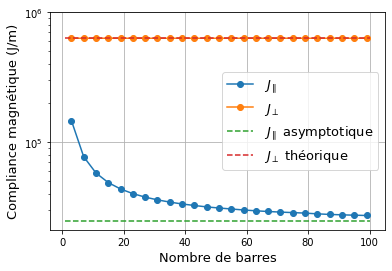

In [11]:
Jpar_theorique = np.pi/2 / (0.5*mu0*mur_fer + 0.5*mu0)
Jperp_theorique = np.pi/2 * (0.5/(mu0*mur_fer) + 0.5/mu0)

plt.semilogy(list(range(3,maxN,4)),J1,'-o')
plt.semilogy(list(range(3,maxN,4)),J2,'-o')
plt.semilogy([1,maxN],[Jpar_theorique,Jpar_theorique],'--')
plt.semilogy([1,maxN],[Jperp_theorique,Jperp_theorique],'--')
plt.legend(["$J_{\parallel}$","$J_{\perp}$","$J_{\parallel}$ asymptotique","$J_{\perp}$ théorique"], fontsize=13)
plt.xlabel("Nombre de barres", fontsize=13)
plt.ylabel("Compliance magnétique (J/m)", fontsize=13)
plt.yticks([1e5,1e6])
plt.grid()
plt.savefig("suite_minimisante_lineaire.pdf",format = 'pdf')